# Let's draw samples from a nested Gaussian Process

We will draw samples from a $(m, n) = (2, 1)$ nested Gaussian process following [Zhu and Dunson (2013)](http://amstat.tandfonline.com/doi/abs/10.1080/01621459.2013.838568). 

For our first trick, we assume values for the random walk and observation noise variabilities and sample from the state space model

$$\begin{align}
Y_j &\sim Z_j \theta_j + \epsilon_j \\
\theta_{j+1} &= G_j \theta_j + \omega_j \\
\theta &= \begin{bmatrix} U \\ DU \\ A \end{bmatrix} \\
\epsilon_j &\sim \mathcal{N}(0, \sigma^2_\epsilon) \\
\omega_j &\sim \mathcal{N}(0, W_j) \\
Z_j &= 
    \begin{pmatrix} 
    1 & 0 & 0
    \end{pmatrix} \\
G_j &= 
    \begin{pmatrix} 
    1 & \delta_j & \frac{\delta_j^2}{2} \\
    0 & 1 & \delta_j \\
    0 & 0 & 1
    \end{pmatrix} \\
W_j & = 
    \begin{pmatrix}
    \frac{\delta_j^3}{3} \sigma_U^2 + \frac{\delta_j^5}{20} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_U^2 + \frac{\delta_j^4}{8} \sigma_A^2 &
    \frac{\delta_j^3}{6} \sigma_A^2 \\
    \frac{\delta_j^2}{2} \sigma_U^2 + \frac{\delta_j^4}{8} \sigma_A^2 &
    \delta_j \sigma_U^2 + \frac{\delta_j^3}{3} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_A^2 \\
    \frac{\delta_j^3}{6} \sigma_A^2 &
    \frac{\delta_j^2}{2} \sigma_A^2 &
    \delta_j \sigma_A^2
    \end{pmatrix} \\
\theta_0 &\sim \mathcal{N}(0, \mathrm{diag}(\sigma^2_\mu, \sigma^2_\mu, \sigma^2_\alpha))
\end{align}$$

In the above, we take $\delta_j \equiv t_{j + 1} - t_j$ and assume $\sigma^2_\mu$ and $\sigma^2_\alpha$ are specified as part of the prior.

# Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sstools as ss
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(12345)  # set random seed

Let's define some functions to make the arrays above:

In [2]:
def Z(delta, sigU, sigA):
    return np.array([1., 0, 0])

In [3]:
def G(delta, sigU, sigA):
    gmat = np.eye(3)
    gmat[0, 1] = delta
    gmat[1, 2] = delta
    gmat[0, 2] = delta**2 / 2
    return gmat

In [4]:
def W(delta, sigU, sigA):
    ssu = sigU**2
    ssa = sigA**2
    wmat = np.empty((3, 3))
    wmat[0, 0] = (delta**3 / 3) * ssu + (delta**5 / 20) * ssa
    wmat[0, 1] = (delta**2 / 2) * ssu + (delta**4 / 8) * ssa
    wmat[0, 2] = (delta**3 / 6) * ssa
    wmat[1, 0] = wmat[0, 1]
    wmat[1, 1] = delta * ssu + (delta**3 / 3) * ssa
    wmat[1, 2] = (delta**2 / 2) * ssa
    wmat[2, 0] = wmat[0, 2]
    wmat[2, 1] = wmat[1, 2]
    wmat[2, 2] = delta * ssa
    
    return wmat

## Load data

In [5]:
data = np.loadtxt('data/blocks_sampled.csv', delimiter=',')
tobs = data[:, 0]
y = data[:, 1].reshape((-1, 1))

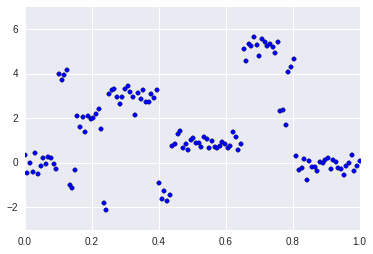

In [6]:
plt.scatter(tobs, y)
plt.xlim(0, 1)
pass

Now we can create the multidimensional arrays needed to sample our state space model:

In [7]:
Nt = y.size
Np = 1
Nm = 3
Nr = 3

sigeps = 0.05
sigA = 0.5
sigU = 0.05
sigmu = 3
sigalpha = 1.

# we need as many deltas as observations
# the last delta corresponds to a hypothetical point at which we want to make a 
# prediction about the state
tpred = 1.1
delta = np.diff(np.concatenate([tobs, [tpred]]))

In [8]:
init_mean = np.zeros(Nm)
init_var = np.diag([sigmu, sigmu, sigalpha])

In [9]:
Zmat = Z(0, sigU, sigA).reshape(1, -1)
    
Hmat = np.array(sigeps).reshape((Np, Np))

In [10]:
Tmat = np.empty((Nt, Nm, Nm))
Rmat = np.eye(Nr)
Qmat = np.empty((Nt, Nr, Nr))

for t in range(Nt):
    Tmat[t] = G(delta[t], sigU, sigA)
    Qmat[t] = W(delta[t], sigU, sigA)

In [11]:
Ns = 500  # number of samples

alpha_samples = np.empty((Ns, Nt, Nm))

In [12]:
for idx in range(Ns):
    alpha_samples[idx] = ss.simulate(y, init_mean, init_var, Zmat, Hmat, Tmat, Rmat, Qmat)

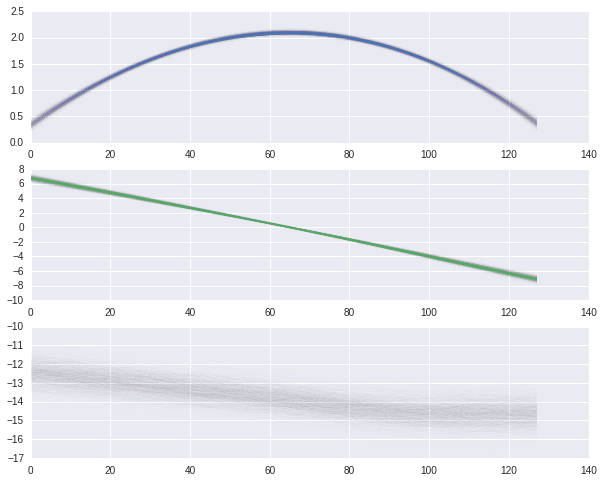

In [13]:
trans = 5 / Ns
plt.figure(figsize=(10, 8))

for idx in range(Nm):
    plt.subplot(Nm, 1, idx + 1)
    plt.plot(alpha_samples[..., idx].T, color=sns.color_palette()[idx], alpha=trans)
pass